In [1]:
import duckdb
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score
from typing import Dict, List

In [2]:
DATABASE = "../database.db"

In [3]:
EIGHT_HOURS_MS = 1000 * 60 * 60 * 8
EIGHT_HOURS_MS

28800000

In [4]:
with duckdb.connect(DATABASE) as con:
    con.sql("""
    CREATE OR REPLACE TABLE prediction_comparison AS
    SELECT
        r.report_id,
        p.player_id,
        p.name,
        uga.week,
        uga.team,
        uga.opponent AS opp,
        strftime(to_timestamp(r.published_at / 1000), '%m/%d %I:%M %p') AS published_at,
        strftime(to_timestamp(ug.started_at / 1000), '%m/%d %I:%M %p') AS started_at,
        to_timestamp(ug.started_at / 1000)::date = to_timestamp(r.published_at / 1000)::date AS published_same_day,
        (ug.started_at - r.published_at) <= 28800000 AS published_within_eight_hours,
        ugo.was_played,
        ugo.ppr_scoring_fantasy_points,
        ugo.ppr_scoring_position_rank,
        ugo.rushing_touchdowns,
        ugo.receiving_touchdowns,
        ugo.rushing_attempts AS att,
        ugo.receiving_targets AS tgt,
        att + tgt AS touches,
        CASE
            WHEN touches >= 20 THEN 'high'
            WHEN touches >= 10 THEN 'medium'
            WHEN touches < 10 THEN 'low'
            ELSE 'unknown'
        END AS actual,
        rp.expected_workload AS expect,
        rp.reason_category AS reason,
        if(actual = 'low', 1, 0) AS is_lo,
        if(expect = 'low' AND actual = 'low', 1, 0) AS tp_lo,
        if(expect = 'low' AND actual != 'low', 1, 0) AS fp_lo,
        if(expect != 'low' AND actual = 'low', 1, 0) AS fn_lo,
        if(actual = 'medium', 1, 0) AS is_md,
        if(expect = 'medium' AND actual = 'medium', 1, 0) AS tp_md,
        if(expect = 'medium' AND actual != 'medium', 1, 0) AS fp_md,
        if(expect != 'medium' AND actual = 'medium', 1, 0) AS fn_md,
        if(actual = 'high', 1, 0) AS is_hi,
        if(expect = 'high' AND actual = 'high', 1, 0) AS tp_hi,
        if(expect = 'high' AND actual != 'high', 1, 0) AS fp_hi,
        if(expect != 'high' AND actual = 'high', 1, 0) AS fn_hi,
    FROM comparable_report c
    LEFT JOIN report r
        ON c.report_id = r.report_id
    LEFT JOIN report_game_assignment a
        ON r.report_id = a.report_id
    LEFT JOIN game ug
        ON a.upcoming_game_id = ug.game_id
    LEFT JOIN player_game_assignment uga
        ON a.upcoming_game_id = uga.game_id
        AND r.player_id = uga.player_id
    LEFT JOIN player_game_outcome ugo
        ON uga.game_id = ugo.game_id
        AND uga.player_id = ugo.player_id
    LEFT JOIN report_prediction rp
        ON r.report_id = rp.report_id
    LEFT JOIN player p
        ON r.player_id = p.player_id
    ORDER BY
        ugo.season ASC,
        r.player_id ASC,
        ugo.week ASC
    ;
    """)

    con.sql("""
    SELECT
        report_id,
        name,
        week,
        team,
        opp,
        att,
        tgt,
        touches,
        actual,
        expect,
        reason,
    FROM prediction_comparison
    LIMIT 20
    ;
    """).show()

┌───────────────────┬────────────────┬───────┬─────────┬─────────┬───────┬───────┬─────────┬─────────┬─────────┬─────────────┐
│     report_id     │      name      │ week  │  team   │   opp   │  att  │  tgt  │ touches │ actual  │ expect  │   reason    │
│      varchar      │    varchar     │ int64 │ varchar │ varchar │ int64 │ int64 │  int64  │ varchar │ varchar │   varchar   │
├───────────────────┼────────────────┼───────┼─────────┼─────────┼───────┼───────┼─────────┼─────────┼─────────┼─────────────┤
│ rotoballer_201624 │ Kyle Juszczyk  │     3 │ SF      │ ARI     │     0 │     1 │       1 │ low     │ low     │ injury      │
│ rotoballer_202429 │ Kyle Juszczyk  │     4 │ SF      │ JAX     │     0 │     3 │       3 │ low     │ unknown │ unknown     │
│ rotoballer_209624 │ Kyle Juszczyk  │    15 │ SF      │ TEN     │     0 │     1 │       1 │ low     │ low     │ injury      │
│ rotoballer_211587 │ Ameer Abdullah │    16 │ IND     │ SF      │     0 │     1 │       1 │ low     │ low     

In [5]:
def get_report_detail(report_id: str) -> Dict:
    value = {}
    with duckdb.connect(DATABASE) as con:
        cur = con.sql("""
        SELECT
            r.title,
            r.description,
            pc.name AS player_name,
            pc.week,
            pc.team,
            pc.opp,
            pc.att,
            pc.tgt,
            pc.touches,
            pc.actual,
            pc.expect,
            pc.reason,
            pc.rushing_touchdowns,
            pc.receiving_touchdowns,
            pc.ppr_scoring_fantasy_points,
            pc.ppr_scoring_position_rank,
        FROM report r
        LEFT JOIN prediction_comparison pc
            ON r.report_id = pc.report_id
        WHERE r.report_id = '{report_id}'
        ;
        """.format(report_id=report_id))
        value = cur.df().to_dict(orient="records")[0]
    return value


def show_report_detail(report_id: str):
    value = get_report_detail(report_id)
    print(f"""
Matchup:
Week {value.get("week")}: {value.get("team")} against {value.get("opp")}

Player:
{value.get("player_name")}

Report:
{value.get("title")}
---
{value.get("description")}

Expected Workload:
{value.get("expect")} (due to {value.get("reason")})

Actual Workload:
{value.get("actual")} ({value.get("touches")} touches)
  {value.get("att")} carries
  {value.get("tgt")} targets

Fantasy Value:
  PPR Points: {value.get("ppr_scoring_fantasy_points")}
  Position Rank: #{value.get("ppr_scoring_position_rank")}
    """.strip())


def save_report_detail(report_id: str):
    report_detail = get_report_detail(report_id)
    with open(f"../docs/assets/reports/{report_id}.json", "w") as outfile:
        outfile.write(json.dumps(report_detail))
    return report_detail

In [6]:
LABELS_WORKLOAD_WITH_UNKNOWN = ["low", "medium", "high", "unknown"]
LABELS_WORKLOAD_WITHOUT_UNKNOWN = ["low", "medium", "high"]
LABELS_REASON = ["performance", "injury", "opponent", "unknown"]

classification_cmap = sns.color_palette("viridis", as_cmap=True)

def plot_confusion_matrix(ys, title, cmap):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
    fig.suptitle(title)
    
    y_real = [y.get("actual") for y in ys]
    y_pred = [y.get("expect") for y in ys]
    cm = confusion_matrix(y_real, y_pred, labels=LABELS_WORKLOAD_WITH_UNKNOWN)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LABELS_WORKLOAD_WITH_UNKNOWN)
    disp.plot(ax=ax, cmap=cmap)
    ax.set_title("Workload")
    
    return fig

In [7]:
predictions = []
with duckdb.connect(DATABASE) as con:
    cur = con.sql("""
    SELECT
        actual,
        expect,
    FROM prediction_comparison
    """)
    df_rows = cur.df()
    records = df_rows.to_dict(orient="records")
    predictions.extend(records)

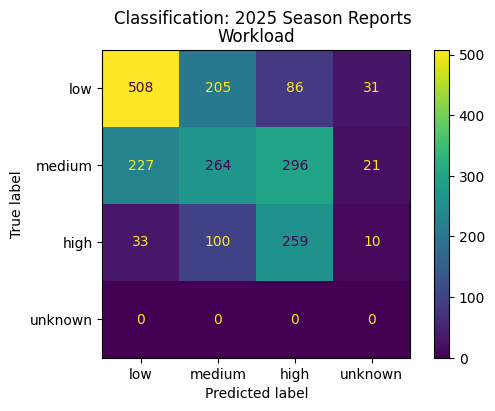

In [8]:
fig = plot_confusion_matrix(predictions, title="Classification: 2025 Season Reports", cmap=classification_cmap)
fig.savefig("../docs/assets/results/classification_season_2025.png")
plt.show()

In [9]:
y_real = [y.get("actual") for y in predictions]
y_pred = [y.get("expect") for y in predictions]

prc_micro = precision_score(y_real, y_pred, labels=LABELS_WORKLOAD_WITHOUT_UNKNOWN, average="micro")
prc_macro = precision_score(y_real, y_pred, labels=LABELS_WORKLOAD_WITHOUT_UNKNOWN, average="macro")
prc_weighted = precision_score(y_real, y_pred, labels=LABELS_WORKLOAD_WITHOUT_UNKNOWN, average="weighted")

rec_micro = recall_score(y_real, y_pred, labels=LABELS_WORKLOAD_WITHOUT_UNKNOWN, average="micro")
rec_macro = recall_score(y_real, y_pred, labels=LABELS_WORKLOAD_WITHOUT_UNKNOWN, average="macro", zero_division=np.nan)
rec_weighted = recall_score(y_real, y_pred, labels=LABELS_WORKLOAD_WITHOUT_UNKNOWN, average="weighted", zero_division=np.nan)

print(f"""
Precision
  Micro:    {(prc_micro * 100):.3f}%
  Macro:    {(prc_macro * 100):.3f}%
  Weighted: {(prc_weighted * 100):.3f}%

Recall
  Micro:    {(rec_micro * 100):.3f}%
  Macro:    {(rec_macro * 100):.3f}%
  Weighted: {(rec_weighted * 100):.3f}%
""".strip())

cls_scores = zip(
    LABELS_WORKLOAD_WITHOUT_UNKNOWN,
    precision_score(y_real, y_pred, labels=LABELS_WORKLOAD_WITHOUT_UNKNOWN, average=None),
    recall_score(y_real, y_pred, labels=LABELS_WORKLOAD_WITHOUT_UNKNOWN, average=None, zero_division=np.nan),
)
print("\nClass\t\tPrecision\tRecall")
for cls, prc, rc in cls_scores:
    print(f"{cls}\t\t{(prc * 100):.3f}%\t\t{(rc * 100):.3f}%")

Precision
  Micro:    52.123%
  Macro:    50.983%
  Weighted: 53.251%

Recall
  Micro:    50.539%
  Macro:    52.769%
  Weighted: 50.539%

Class		Precision	Recall
low		66.146%		61.205%
medium		46.397%		32.673%
high		40.406%		64.428%


In [10]:
with duckdb.connect(DATABASE) as con:
    con.sql("""
    WITH
    metrics AS (
        SELECT
            sum(tp_lo) / sum(tp_lo + fp_lo) AS prc_lo,
            sum(tp_md) / sum(tp_md + fp_md) AS prc_md,
            sum(tp_hi) / sum(tp_hi + fp_hi) AS prc_hi,
            sum(tp_lo) / sum(tp_lo + fn_lo) AS rec_lo,
            sum(tp_md) / sum(tp_md + fn_md) AS rec_md,
            sum(tp_hi) / sum(tp_hi + fn_hi) AS rec_hi,
            mean(is_lo) AS wgt_lo,
            mean(is_md) AS wgt_md,
            mean(is_hi) AS wgt_hi,
            sum(tp_lo + tp_md + tp_hi) / sum(tp_lo + tp_md + tp_hi + fp_lo + fp_md + fp_hi) As micro_prc,
            (prc_lo + prc_md + prc_hi) / 3.0 AS macro_prc,
            ((wgt_lo * prc_lo) + (wgt_md * prc_md) + (wgt_hi * prc_hi)) AS wgt_prc,
            sum(tp_lo + tp_md + tp_hi) / sum(tp_lo + tp_md + tp_hi + fn_lo + fn_md + fn_hi) As micro_rec,
            (rec_lo + rec_md + rec_hi) / 3.0 AS macro_rec,
            ((wgt_lo * rec_lo) + (wgt_md * rec_md) + (wgt_hi * rec_hi)) AS wgt_rec,
        FROM prediction_comparison
    )
    SELECT
        format('{:.3f}%', micro_prc * 100) AS micro_precision,
        format('{:.3f}%', macro_prc * 100) AS macro_precision,
        format('{:.3f}%', wgt_prc * 100) AS weighted_precision,
    FROM metrics
    ;
    """).show()

┌─────────────────┬─────────────────┬────────────────────┐
│ micro_precision │ macro_precision │ weighted_precision │
│     varchar     │     varchar     │      varchar       │
├─────────────────┼─────────────────┼────────────────────┤
│ 52.123%         │ 50.983%         │ 53.251%            │
└─────────────────┴─────────────────┴────────────────────┘



In [11]:
with duckdb.connect(DATABASE) as con:
    con.sql("""
    WITH
    metrics AS (
        SELECT
            reason,
            sum(tp_lo) / sum(tp_lo + fp_lo) AS prc_lo,
            sum(tp_md) / sum(tp_md + fp_md) AS prc_md,
            sum(tp_hi) / sum(tp_hi + fp_hi) AS prc_hi,
            sum(tp_lo) / sum(tp_lo + fn_lo) AS rec_lo,
            sum(tp_md) / sum(tp_md + fn_md) AS rec_md,
            sum(tp_hi) / sum(tp_hi + fn_hi) AS rec_hi,
            mean(is_lo) AS wgt_lo,
            mean(is_md) AS wgt_md,
            mean(is_hi) AS wgt_hi,
            sum(tp_lo + tp_md + tp_hi) / sum(tp_lo + tp_md + tp_hi + fp_lo + fp_md + fp_hi) As micro_prc,
            (prc_lo + prc_md + prc_hi) / 3.0 AS macro_prc,
            ((wgt_lo * prc_lo) + (wgt_md * prc_md) + (wgt_hi * prc_hi)) AS wgt_prc,
            sum(tp_lo + tp_md + tp_hi) / sum(tp_lo + tp_md + tp_hi + fn_lo + fn_md + fn_hi) As micro_rec,
            (rec_lo + rec_md + rec_hi) / 3.0 AS macro_rec,
            ((wgt_lo * rec_lo) + (wgt_md * rec_md) + (wgt_hi * rec_hi)) AS wgt_rec,
            count(1) AS reports,
        FROM prediction_comparison
        GROUP BY reason
        ORDER BY wgt_prc DESC
    )
    SELECT
        reason,
        reports,
        format('{:.3f}%', wgt_prc * 100) AS weighted_precision,
        format('{:.3f}%', wgt_rec * 100) AS weighted_recall,
        format('{:.3f}%', prc_lo * 100) AS precision_lo,
        format('{:.3f}%', prc_md * 100) AS precision_md,
        format('{:.3f}%', prc_hi * 100) AS precision_hi,
    FROM metrics
    ;
    """).show()

┌─────────────┬─────────┬────────────────────┬─────────────────┬──────────────┬──────────────┬──────────────┐
│   reason    │ reports │ weighted_precision │ weighted_recall │ precision_lo │ precision_md │ precision_hi │
│   varchar   │  int64  │      varchar       │     varchar     │   varchar    │   varchar    │   varchar    │
├─────────────┼─────────┼────────────────────┼─────────────────┼──────────────┼──────────────┼──────────────┤
│ performance │     802 │ 55.011%            │ 54.115%         │ 67.917%      │ 49.130%      │ 47.734%      │
│ injury      │     870 │ 54.026%            │ 50.000%         │ 70.171%      │ 38.813%      │ 29.577%      │
│ opponent    │     298 │ 50.707%            │ 47.987%         │ 46.000%      │ 57.692%      │ 39.362%      │
│ unknown     │      70 │ 48.882%            │ 27.143%         │ 63.158%      │ 37.500%      │ 33.333%      │
└─────────────┴─────────┴────────────────────┴─────────────────┴──────────────┴──────────────┴──────────────┘



In [12]:
with duckdb.connect(DATABASE) as con:
    con.sql("""
    WITH
    metrics AS (
        SELECT
            week,
            sum(tp_lo) / sum(tp_lo + fp_lo) AS prc_lo,
            sum(tp_md) / sum(tp_md + fp_md) AS prc_md,
            sum(tp_hi) / sum(tp_hi + fp_hi) AS prc_hi,
            sum(tp_lo) / sum(tp_lo + fn_lo) AS rec_lo,
            sum(tp_md) / sum(tp_md + fn_md) AS rec_md,
            sum(tp_hi) / sum(tp_hi + fn_hi) AS rec_hi,
            mean(is_lo) AS wgt_lo,
            mean(is_md) AS wgt_md,
            mean(is_hi) AS wgt_hi,
            sum(tp_lo + tp_md + tp_hi) / sum(tp_lo + tp_md + tp_hi + fp_lo + fp_md + fp_hi) As micro_prc,
            (prc_lo + prc_md + prc_hi) / 3.0 AS macro_prc,
            ((wgt_lo * prc_lo) + (wgt_md * prc_md) + (wgt_hi * prc_hi)) AS wgt_prc,
            sum(tp_lo + tp_md + tp_hi) / sum(tp_lo + tp_md + tp_hi + fn_lo + fn_md + fn_hi) As micro_rec,
            (rec_lo + rec_md + rec_hi) / 3.0 AS macro_rec,
            ((wgt_lo * rec_lo) + (wgt_md * rec_md) + (wgt_hi * rec_hi)) AS wgt_rec,
            count(1) AS reports,
        FROM prediction_comparison
        GROUP BY week
        ORDER BY week ASC
    )
    SELECT
        week,
        reports,
        format('{:.3f}%', wgt_prc * 100) AS weighted_precision,
        format('{:.3f}%', wgt_rec * 100) AS weighted_recall,
    FROM metrics
    ;
    """).show()

┌───────┬─────────┬────────────────────┬─────────────────┐
│ week  │ reports │ weighted_precision │ weighted_recall │
│ int64 │  int64  │      varchar       │     varchar     │
├───────┼─────────┼────────────────────┼─────────────────┤
│     2 │      38 │ 53.935%            │ 55.263%         │
│     3 │      46 │ 73.278%            │ 71.739%         │
│     4 │      49 │ 52.521%            │ 48.980%         │
│     5 │      87 │ 74.513%            │ 65.517%         │
│     6 │     148 │ 56.219%            │ 54.730%         │
│     7 │     125 │ 52.933%            │ 48.000%         │
│     8 │     124 │ 44.805%            │ 37.097%         │
│     9 │     146 │ 59.316%            │ 56.849%         │
│    10 │     177 │ 44.769%            │ 43.503%         │
│    11 │     168 │ 52.744%            │ 50.000%         │
│    12 │     147 │ 54.982%            │ 47.619%         │
│    13 │     166 │ 51.086%            │ 50.602%         │
│    14 │     151 │ 57.560%            │ 52.318%        

In [13]:
with duckdb.connect(DATABASE) as con:
    con.sql("""
    WITH
    metrics AS (
        SELECT
            player_id,
            max(name) AS player_name,
            sum(tp_lo) / sum(tp_lo + fp_lo) AS prc_lo,
            sum(tp_md) / sum(tp_md + fp_md) AS prc_md,
            sum(tp_hi) / sum(tp_hi + fp_hi) AS prc_hi,
            sum(tp_lo) / sum(tp_lo + fn_lo) AS rec_lo,
            sum(tp_md) / sum(tp_md + fn_md) AS rec_md,
            sum(tp_hi) / sum(tp_hi + fn_hi) AS rec_hi,
            mean(is_lo) AS wgt_lo,
            mean(is_md) AS wgt_md,
            mean(is_hi) AS wgt_hi,
            sum(tp_lo + tp_md + tp_hi) / sum(tp_lo + tp_md + tp_hi + fp_lo + fp_md + fp_hi) As micro_prc,
            (prc_lo + prc_md + prc_hi) / 3.0 AS macro_prc,
            ((wgt_lo * prc_lo) + (wgt_md * prc_md) + (wgt_hi * prc_hi)) AS wgt_prc,
            sum(tp_lo + tp_md + tp_hi) / sum(tp_lo + tp_md + tp_hi + fn_lo + fn_md + fn_hi) As micro_rec,
            (rec_lo + rec_md + rec_hi) / 3.0 AS macro_rec,
            ((wgt_lo * rec_lo) + (wgt_md * rec_md) + (wgt_hi * rec_hi)) AS wgt_rec,
            count(1) AS reports,
            sum(was_played) AS games,
        FROM prediction_comparison
        GROUP BY player_id
    )
    SELECT
        player_id,
        player_name,
        reports,
        games,
        format('{:.1f}%', micro_prc * 100) AS micro_precision,
        format('{:.1f}%', micro_rec * 100) AS micro_recall,
    FROM metrics
    WHERE NOT isnan(micro_prc)
    ORDER BY
        micro_prc DESC,
        games DESC
    LIMIT 10
    ;
    """).show()

┌───────────┬────────────────┬─────────┬────────┬─────────────────┬──────────────┐
│ player_id │  player_name   │ reports │ games  │ micro_precision │ micro_recall │
│   int64   │    varchar     │  int64  │ int128 │     varchar     │   varchar    │
├───────────┼────────────────┼─────────┼────────┼─────────────────┼──────────────┤
│      2749 │ Raheem Mostert │       6 │      6 │ 100.0%          │ 83.3%        │
│      6012 │ Travis Homer   │       4 │      4 │ 100.0%          │ 100.0%       │
│     11299 │ Zavier Scott   │       3 │      3 │ 100.0%          │ 100.0%       │
│     11577 │ Will Shipley   │       3 │      3 │ 100.0%          │ 100.0%       │
│     12504 │ Kaleb Johnson  │       4 │      3 │ 100.0%          │ 100.0%       │
│      1379 │ Kyle Juszczyk  │       3 │      3 │ 100.0%          │ 66.7%        │
│      4137 │ James Conner   │       7 │      3 │ 100.0%          │ 100.0%       │
│      6828 │ A.J. Dillon    │       3 │      3 │ 100.0%          │ 100.0%       │
│   

In [14]:
with duckdb.connect(DATABASE) as con:
    con.sql("""
    SELECT
        report_id,
        name,
        week,
        team,
        opp,
        att,
        tgt,
        touches,
        actual,
        expect,
        reason,
    FROM prediction_comparison
    WHERE player_id = 4137
    LIMIT 20
    ;
    """).show()

┌───────────────────┬──────────────┬───────┬─────────┬─────────┬───────┬───────┬─────────┬─────────┬─────────┬─────────────┐
│     report_id     │     name     │ week  │  team   │   opp   │  att  │  tgt  │ touches │ actual  │ expect  │   reason    │
│      varchar      │   varchar    │ int64 │ varchar │ varchar │ int64 │ int64 │  int64  │ varchar │ varchar │   varchar   │
├───────────────────┼──────────────┼───────┼─────────┼─────────┼───────┼───────┼─────────┼─────────┼─────────┼─────────────┤
│ rotoballer_201502 │ James Conner │     2 │ ARI     │ CAR     │    11 │     1 │      12 │ medium  │ medium  │ opponent    │
│ rotoballer_201082 │ James Conner │     2 │ ARI     │ CAR     │    11 │     1 │      12 │ medium  │ medium  │ performance │
│ rotoballer_202091 │ James Conner │     3 │ ARI     │ SF      │     9 │     4 │      13 │ medium  │ medium  │ opponent    │
│ rotoballer_202321 │ James Conner │     4 │ ARI     │ SEA     │     0 │     0 │       0 │ low     │ low     │ injury      │


In [15]:
with duckdb.connect(DATABASE) as con:
    con.sql("""
    WITH
    metrics AS (
        SELECT
            published_same_day,
            sum(tp_lo) / sum(tp_lo + fp_lo) AS prc_lo,
            sum(tp_md) / sum(tp_md + fp_md) AS prc_md,
            sum(tp_hi) / sum(tp_hi + fp_hi) AS prc_hi,
            sum(tp_lo) / sum(tp_lo + fn_lo) AS rec_lo,
            sum(tp_md) / sum(tp_md + fn_md) AS rec_md,
            sum(tp_hi) / sum(tp_hi + fn_hi) AS rec_hi,
            mean(is_lo) AS wgt_lo,
            mean(is_md) AS wgt_md,
            mean(is_hi) AS wgt_hi,
            sum(tp_lo + tp_md + tp_hi) / sum(tp_lo + tp_md + tp_hi + fp_lo + fp_md + fp_hi) As micro_prc,
            (prc_lo + prc_md + prc_hi) / 3.0 AS macro_prc,
            ((wgt_lo * prc_lo) + (wgt_md * prc_md) + (wgt_hi * prc_hi)) AS wgt_prc,
            sum(tp_lo + tp_md + tp_hi) / sum(tp_lo + tp_md + tp_hi + fn_lo + fn_md + fn_hi) As micro_rec,
            (rec_lo + rec_md + rec_hi) / 3.0 AS macro_rec,
            ((wgt_lo * rec_lo) + (wgt_md * rec_md) + (wgt_hi * rec_hi)) AS wgt_rec,
            count(1) AS reports,
        FROM prediction_comparison
        GROUP BY published_same_day
        ORDER BY published_same_day DESC
    )
    SELECT
        published_same_day,
        reports,
        format('{:.3f}%', wgt_prc * 100) AS weighted_precision,
        format('{:.3f}%', wgt_rec * 100) AS weighted_recall,
        format('{:.3f}%', prc_lo * 100) AS precision_lo,
        format('{:.3f}%', prc_md * 100) AS precision_md,
        format('{:.3f}%', prc_hi * 100) AS precision_hi,
    FROM metrics
    ;
    """).show()

┌────────────────────┬─────────┬────────────────────┬─────────────────┬──────────────┬──────────────┬──────────────┐
│ published_same_day │ reports │ weighted_precision │ weighted_recall │ precision_lo │ precision_md │ precision_hi │
│      boolean       │  int64  │      varchar       │     varchar     │   varchar    │   varchar    │   varchar    │
├────────────────────┼─────────┼────────────────────┼─────────────────┼──────────────┼──────────────┼──────────────┤
│ true               │     111 │ 49.394%            │ 47.748%         │ 62.222%      │ 41.667%      │ 38.462%      │
│ false              │    1929 │ 53.457%            │ 50.700%         │ 66.390%      │ 46.606%      │ 40.532%      │
└────────────────────┴─────────┴────────────────────┴─────────────────┴──────────────┴──────────────┴──────────────┘



In [16]:
with duckdb.connect(DATABASE) as con:
    con.sql("""
    SELECT
        report_id,
        name,
        week,
        team,
        opp,
        att,
        tgt,
        touches,
        actual,
        expect,
        reason,
    FROM prediction_comparison
    WHERE
        reason = 'injury'
        AND expect = 'low'
        AND actual = 'low'
        AND ppr_scoring_fantasy_points < 10
    ORDER BY touches DESC
    LIMIT 20
    ;
    """).show()

┌───────────────────┬─────────────────┬───────┬─────────┬─────────┬───────┬───────┬─────────┬─────────┬─────────┬─────────┐
│     report_id     │      name       │ week  │  team   │   opp   │  att  │  tgt  │ touches │ actual  │ expect  │ reason  │
│      varchar      │     varchar     │ int64 │ varchar │ varchar │ int64 │ int64 │  int64  │ varchar │ varchar │ varchar │
├───────────────────┼─────────────────┼───────┼─────────┼─────────┼───────┼───────┼─────────┼─────────┼─────────┼─────────┤
│ rotoballer_206214 │ Alvin Kamara    │     9 │ NO      │ LAR     │     6 │     3 │       9 │ low     │ low     │ injury  │
│ rotoballer_206351 │ Alvin Kamara    │     9 │ NO      │ LAR     │     6 │     3 │       9 │ low     │ low     │ injury  │
│ rotoballer_204308 │ Samaje Perine   │     6 │ CIN     │ GB      │     6 │     3 │       9 │ low     │ low     │ injury  │
│ rotoballer_205386 │ Aaron Jones     │     8 │ MIN     │ LAC     │     5 │     4 │       9 │ low     │ low     │ injury  │
│ rotoba

In [17]:
show_report_detail("rotoballer_206351")

Matchup:
Week 9: NO against LAR

Player:
Alvin Kamara

Report:
Alvin Kamara Hopes to Bounce Back Against Rams
---
New Orleans Saints running back Alvin Kamara is officially listed as questionable to play against the Rams, currently nursing an ankle issue. Head coach Kellen Moore said he is trending in the right direction, so the 30-year-old is likely to suit up. Kamara has struggled all year, averaging a career-low 4.0 yards per touch and scoring only once, back in Week 1 against the Cardinals. He never built much chemistry with Spencer Rattler in the passing game, but with Tyler Shough under center, there is hope Kamara gets more involved as a receiver. The Saints are averaging just 93.6 rushing yards per game, while the Rams allow 105.9, so Kamara retains low-end RB2/Flex appeal if healthy.

Expected Workload:
low (due to injury)

Actual Workload:
low (9 touches)
  6 carries
  3 targets

Fantasy Value:
  PPR Points: 0
  Position Rank: #60


In [18]:
with duckdb.connect(DATABASE) as con:
    con.sql("""
    SELECT
        report_id,
        name,
        week,
        team,
        opp,
        att,
        tgt,
        touches,
        actual,
        expect,
        reason,
    FROM prediction_comparison
    WHERE
        player_id = 7021
        AND week = 5
    ORDER BY week ASC
    LIMIT 10
    ;
    """).show()

┌───────────────────┬─────────────┬───────┬─────────┬─────────┬───────┬───────┬─────────┬─────────┬─────────┬─────────┐
│     report_id     │    name     │ week  │  team   │   opp   │  att  │  tgt  │ touches │ actual  │ expect  │ reason  │
│      varchar      │   varchar   │ int64 │ varchar │ varchar │ int64 │ int64 │  int64  │ varchar │ varchar │ varchar │
├───────────────────┼─────────────┼───────┼─────────┼─────────┼───────┼───────┼─────────┼─────────┼─────────┼─────────┤
│ rotoballer_203375 │ Rico Dowdle │     5 │ CAR     │ MIA     │    23 │     4 │      27 │ high    │ high    │ injury  │
│ rotoballer_203659 │ Rico Dowdle │     5 │ CAR     │ MIA     │    23 │     4 │      27 │ high    │ high    │ injury  │
└───────────────────┴─────────────┴───────┴─────────┴─────────┴───────┴───────┴─────────┴─────────┴─────────┴─────────┘



In [19]:
show_report_detail("rotoballer_203375")

Matchup:
Week 5: CAR against MIA

Player:
Rico Dowdle

Report:
Rico Dowdle in Line For an Increased Workload in Week 5
---
Carolina Panthers running back and former Dallas Cowboy, Rico Dowdle, is set to be the lead back in the Panthers' backfield in Week 5 against the Miami Dolphins, with Chuba Hubbard (calf) ruled out for Week 5. Hubbard is considered week-to-week, so Dowdle isn't expected to be a hot commodity for a season-long play, but he immediately rises in the Week 5 ranks and becomes a top-25 running back against the Dolphins defense, which allows the seventh most fantasy points to the running back position. Dowdle is no slouch either; last year with the Cowboys, he accumulated 1,328 all-purpose yards and five touchdowns. Rookie running back Trevor Etienne becomes the team's RB2 and should also be in line for additional carries.

Expected Workload:
high (due to injury)

Actual Workload:
high (27 touches)
  23 carries
  4 targets

Fantasy Value:
  PPR Points: 32
  Position Rank:

In [20]:
show_report_detail("rotoballer_203659")

Matchup:
Week 5: CAR against MIA

Player:
Rico Dowdle

Report:
Rico Dowdle Offers Streaming Value for Week 5
---
Carolina Panthers running back Rico Dowdle will take over as the lead back ahead of the Week 5 matchup against the Miami Dolphins. The Panthers are without Chuba Hubbard (calf) this week, so Dowdle is the next man up. Over the last two games, Dowdle has rushed 19 times for 62 yards and one touchdown. The 27-year-old has been working as the primary backup, but should offer streaming value as the starter. Trevor Etienne and DeeJay Dallas could also be involved, but Dowdle is the best option of the bunch. Given the injuries and byes in Week 5, Dowdle is looking like a viable RB2 to plenty of fantasy managers.

Expected Workload:
high (due to injury)

Actual Workload:
high (27 touches)
  23 carries
  4 targets

Fantasy Value:
  PPR Points: 32
  Position Rank: #1


In [21]:
# Good marquee example for introduction
save_report_detail("rotoballer_203375")

{'title': 'Rico Dowdle in Line For an Increased Workload in Week 5',
 'description': "Carolina Panthers running back and former Dallas Cowboy, Rico Dowdle, is set to be the lead back in the Panthers' backfield in Week 5 against the Miami Dolphins, with Chuba Hubbard (calf) ruled out for Week 5. Hubbard is considered week-to-week, so Dowdle isn't expected to be a hot commodity for a season-long play, but he immediately rises in the Week 5 ranks and becomes a top-25 running back against the Dolphins defense, which allows the seventh most fantasy points to the running back position. Dowdle is no slouch either; last year with the Cowboys, he accumulated 1,328 all-purpose yards and five touchdowns. Rookie running back Trevor Etienne becomes the team's RB2 and should also be in line for additional carries.",
 'player_name': 'Rico Dowdle',
 'week': 5,
 'team': 'CAR',
 'opp': 'MIA',
 'att': 23,
 'tgt': 4,
 'touches': 27,
 'actual': 'high',
 'expect': 'high',
 'reason': 'injury',
 'rushing_touc

In [22]:
with duckdb.connect(DATABASE) as con:
    con.sql("""
    SELECT
        report_id,
        name,
        week,
        team,
        opp,
        att,
        tgt,
        touches,
        actual,
        expect,
        reason,
    FROM prediction_comparison
    WHERE
        reason = 'injury'
        AND expect = 'low'
        AND actual = 'low'
    ORDER BY touches DESC
    LIMIT 10
    ;
    """).show()

┌───────────────────┬─────────────────┬───────┬─────────┬─────────┬───────┬───────┬─────────┬─────────┬─────────┬─────────┐
│     report_id     │      name       │ week  │  team   │   opp   │  att  │  tgt  │ touches │ actual  │ expect  │ reason  │
│      varchar      │     varchar     │ int64 │ varchar │ varchar │ int64 │ int64 │  int64  │ varchar │ varchar │ varchar │
├───────────────────┼─────────────────┼───────┼─────────┼─────────┼───────┼───────┼─────────┼─────────┼─────────┼─────────┤
│ rotoballer_206214 │ Alvin Kamara    │     9 │ NO      │ LAR     │     6 │     3 │       9 │ low     │ low     │ injury  │
│ rotoballer_206351 │ Alvin Kamara    │     9 │ NO      │ LAR     │     6 │     3 │       9 │ low     │ low     │ injury  │
│ rotoballer_204308 │ Samaje Perine   │     6 │ CIN     │ GB      │     6 │     3 │       9 │ low     │ low     │ injury  │
│ rotoballer_205386 │ Aaron Jones     │     8 │ MIN     │ LAC     │     5 │     4 │       9 │ low     │ low     │ injury  │
│ rotoba

In [23]:
show_report_detail("rotoballer_207739")

Matchup:
Week 11: ARI against SF

Player:
Zonovan Knight

Report:
Bam Knight Considered Questionable for Week 11
---
Arizona Cardinals running back Bam Knight (ankle) was limited in practice all week and is listed as questionable to play on Sunday against the division-rival San Francisco 49ers in Week 11. Knight was once again the team's starting RB in last weekend's blowout loss to the Seattle Seahawks, with Trey Benson (knee) still on Injured Reserve, but now his status is up in the air. The 24-year-old should be able to suit up, but his ankle injury could open the door for both Emari Demercado and Michael Carter to see more backfield touches. Knight had only 33 scrimmage yards on 11 touches before his ankle injury in Week 10, and he hasn't been very efficient since taking over in Arizona. Even when healthy, Knight's RB1 role hasn't been very secure, with Demercado seeing 14 carries in Week 9. If Knight is active, he'll be a pretty wishy-washy RB3/flex with limited upside for fantasy

In [24]:
# Good example of unknown expected level
save_report_detail("rotoballer_207371")

{'title': 'Sloppy Offense Leads To Reduced Touches For Aaron Jones Sr., Jordan Mason',
 'description': 'Minnesota Vikings running backs Aaron Jones Sr. and Jordan Mason combined for only 13 carries in the team\'s Week 10 loss to Baltimore, but the running game was hindered by a significant number of presnap penalties. Minnesota committed a whopping eight false start penalties -- the most by a team since 2011 -- including five of them on first-and-10 situations, and also committed three turnovers. Both Jones and Mason were above five years per carry, but Minnesota found itself in so many poor down-and-distance situations that it attempted 42 passes. "When you average six yards a play on offense, it\'s all for naught if you\'re going to be giving back so many of those yards in different capacities," Vikings head coach Kevin O\'Connell said. It was a frustrating day for managers who started Jones or Mason, but an aberrational amount of penalties suggests Minnesota\'s top two running backs

In [25]:
# Good example of high expectations, low performance
save_report_detail("rotoballer_203459")

{'title': 'Saquon Barkley Looks to Overcome Denver Defense',
 'description': 'Philadelphia Eagles running back Saquon Barkley has failed to eclipse 50 rushing yards in each of his last two games, and will face another hurdle this Sunday against the Broncos. Denver is allowing 99.3 rushing yards per game this season-just one of 11 teams to average under 100. They also stifled Bengals RB Chase Brown on Monday, keeping him to 40 yards on 10 carries with his longest attempt going for six yards. However, Philly does have a much stronger offensive line than Cincinnati does, and Barkley averages more yards per carry (3.1) than Brown (2.3). Even with a couple things going against him, Barkley remains a definitive RB1 for Week 5.',
 'player_name': 'Saquon Barkley',
 'week': 5,
 'team': 'PHI',
 'opp': 'DEN',
 'att': 6,
 'tgt': 3,
 'touches': 9,
 'actual': 'low',
 'expect': 'high',
 'reason': 'opponent',
 'rushing_touchdowns': 0,
 'receiving_touchdowns': 1,
 'ppr_scoring_fantasy_points': 17,
 'pp

In [26]:
# Good example of low expectations based on opponent
save_report_detail("rotoballer_206534")

{'title': 'Ashton Jeanty Salvages his Day With Receiving Touchdown in Week 9',
 'description': "Las Vegas Raiders rookie first-round running back Ashton Jeanty had another mediocre performance on the ground in the team's Week 9 overtime loss to the visiting Jacksonville Jaguars on Sunday, but he salvaged his day for fantasy managers by catching all five of his targets for 47 yards and a touchdown through the air. On the ground, Jeanty handled a team-high 13 carries for 42 yards (3.2 yards per carry). The 21-year-old was able to bounce back coming out of the bye week after he had a season-low six carries for 21 yards and only one catch for 13 yards in the Week 7 blowout loss to the Kansas City Chiefs. It's been slow going for Jeanty the last three games behind a shaky Raiders offensive line, and things won't get any easier on a short week on Thursday Night Football against a stout Denver Broncos defense in Week 10. Through his first eight NFL games, Jeanty has three rushing scores and t

In [27]:
# Good example of injury warning
save_report_detail("rotoballer_207739")

{'title': 'Bam Knight Considered Questionable for Week 11',
 'description': "Arizona Cardinals running back Bam Knight (ankle) was limited in practice all week and is listed as questionable to play on Sunday against the division-rival San Francisco 49ers in Week 11. Knight was once again the team's starting RB in last weekend's blowout loss to the Seattle Seahawks, with Trey Benson (knee) still on Injured Reserve, but now his status is up in the air. The 24-year-old should be able to suit up, but his ankle injury could open the door for both Emari Demercado and Michael Carter to see more backfield touches. Knight had only 33 scrimmage yards on 11 touches before his ankle injury in Week 10, and he hasn't been very efficient since taking over in Arizona. Even when healthy, Knight's RB1 role hasn't been very secure, with Demercado seeing 14 carries in Week 9. If Knight is active, he'll be a pretty wishy-washy RB3/flex with limited upside for fantasy managers.",
 'player_name': 'Zonovan Kn